Your objective is to use any method you want to develop an automatic pipeline with the training data (“train.tif” and “train_ground_truth.shp”) and to count the number of plants in the “test.tif” file as accurately as possible. 

However, building a highly accurate model is only part of the story. We also want to know how you do it. As such, we’ll also be looking for you to deliver a 5-page slides on your approach. Additionally, we’d like you to put your codes in a zip file and send to us which should to include python files (.py) that can be run in command line and a notebook file (.ipynb) to walk through the pipeline. 

The final component of the evaluation is to generate georeferenced maps using the stand count results from your automatic pipeline: a plant population map (the unit for the pixel is plants/ac) and a plant size map (the unit for the pixel is cm).  

In [2]:
import matplotlib
new_style = {'grid': False}
matplotlib.rc('axes', **new_style)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
from shapely.geometry import shape
# from osgeo import gdal, osr

import geopandas as gpd


a TIFF file: “train.tif”. 
- This is an RGB map over a half of a corn field. The corn plants are at V2-3 growth stage. 

 
a TIFF file: “test.tif”.
- This is an RGB map over the other half of the corn field. The corn plants are at V2-3 growth stage. 

 
a shapefile: “train_ground_truth.shp” and its related files (you will need to download all of them to view the shapefile).
- This is the ground truth data for the stand count case study, which can be used to develop and evaluate your automatic stand counting method. You can open in QGIS or any GIS software. Each point in the file represents the location of an individual plant. 

In [3]:
# def fnames
import os
dpath = 'data/'
trainf = os.path.join(dpath, 'train.tif')
testf = os.path.join(dpath, 'test.tif')
truthf = os.path.join(dpath, 'train_ground_truth.shp')

assert os.path.isfile(trainf)
assert os.path.isfile(testf)
assert os.path.isfile(truthf)

In [4]:
truth = gpd.read_file(truthf)

In [5]:
truth.columns

Index(['id', 'geometry'], dtype='object')

In [6]:
len(truth)

9534

In [7]:
truth.geometry[:5]

0    POINT (-89.81287 35.12559)
1    POINT (-89.81287 35.12559)
2    POINT (-89.81287 35.12559)
3    POINT (-89.81287 35.12558)
4    POINT (-89.81287 35.12558)
Name: geometry, dtype: geometry

In [8]:
# https://www.spatialreference.org/ref/epsg/4326/
truth.crs

{'init': 'epsg:4326'}

In [9]:
datasetTrain = rasterio.open(trainf)
print(datasetTrain.meta)

datasetTest = rasterio.open(testf)
print(datasetTest.meta)

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 6735, 'height': 5214, 'count': 4, 'crs': CRS.from_epsg(4326), 'transform': Affine(7.23197880395e-08, 0.0, -89.8129073071484,
       0.0, -7.23197880395e-08, 35.12562160893812)}
{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 6720, 'height': 4865, 'count': 4, 'crs': CRS.from_epsg(4326), 'transform': Affine(7.23197880395e-08, 0.0, -89.81290840659209,
       0.0, -7.23197880395e-08, 35.125241201422014)}


In [10]:
# No data values for all channels
print(datasetTrain.nodatavals)
print(datasetTest.nodatavals)

(None, None, None, None)
(None, None, None, None)


In [11]:
np.seterr(divide='ignore', invalid='ignore')

def normalize(array):
    array_min, array_max = array.min(), array.max()
    return (array - array_min) / (array_max - array_min)

In [12]:
with rasterio.open(trainf) as src:
    profile = src.profile
    print(src.profile)
    
    (xmin, ymin, xmax, ymax) = src.bounds
    width = src.width
    height = src.height
#    print(src.descriptions)
    train_img1 = src.read(1).astype(float)
    train_img2 = src.read(2).astype(float)
    train_img3 = src.read(3).astype(float)
    train_img4 = src.read(4).astype(float)

    # Normalize band 
    train_img4_norm = normalize(train_img4)
    train_img3_norm = normalize(train_img3)
    train_img2_norm = normalize(train_img2)
    train_img1_norm = normalize(train_img1)    

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 6735, 'height': 5214, 'count': 4, 'crs': CRS.from_epsg(4326), 'transform': Affine(7.23197880395e-08, 0.0, -89.8129073071484,
       0.0, -7.23197880395e-08, 35.12562160893812), 'tiled': False, 'interleave': 'pixel'}


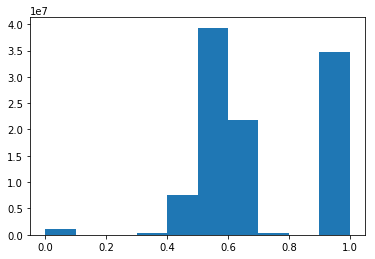

In [13]:
# Stack bands
false_RGB = np.dstack((train_img4_norm, train_img3_norm, train_img2_norm))

plt.hist(false_RGB.flatten())
plt.show();

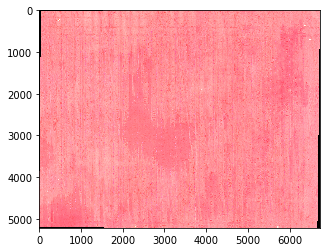

In [14]:
# View the color composite
plt.imshow(false_RGB)
plt.show();

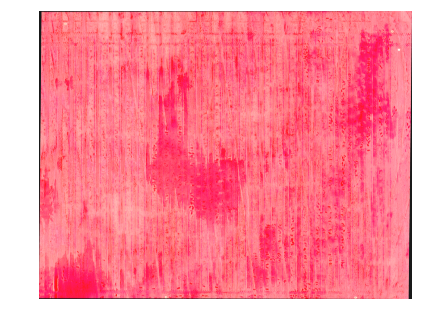

In [15]:
from skimage import exposure
p5, p98 = np.percentile(false_RGB, (5, 98))                             
rgbStretched = exposure.rescale_intensity(false_RGB, in_range=(p5, p98)) # Perform contrast stretch on RGB range
rgbStretched = exposure.adjust_gamma(rgbStretched, 0.5)                  # Perform Gamma Correctio

fig = plt.figure()
ax = plt.Axes(fig,[0,0,1,1]) 
ax.set_axis_off()                                            # Turn off axes
fig.add_axes(ax)
ax.imshow(rgbStretched, interpolation='bilinear', alpha=0.9) # Plot a natural color RGB
plt.show();

In [15]:
# read all bands and compute summary stats
TrainALLbands = datasetTrain.read()
stats = [] 
for band in TrainALLbands:
     stats.append({
         'min': band.min(),
         'mean': band.mean(),
         'median': np.median(band),
         'max': band.max()})
print(stats)

[{'min': 0, 'mean': 157.5017987093739, 'median': 160.0, 'max': 255}, {'min': 0, 'mean': 148.84732601308394, 'median': 151.0, 'max': 255}, {'min': 0, 'mean': 139.83951018174187, 'median': 143.0, 'max': 255}, {'min': 0, 'mean': 252.25973842908803, 'median': 255.0, 'max': 255}]


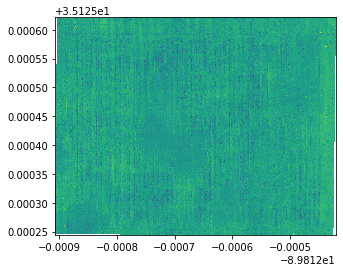

<Figure size 432x288 with 0 Axes>

In [16]:
# plot train
from rasterio.plot import show
show(datasetTrain)
plt.savefig('train_basic.png', bbox_inches="tight")

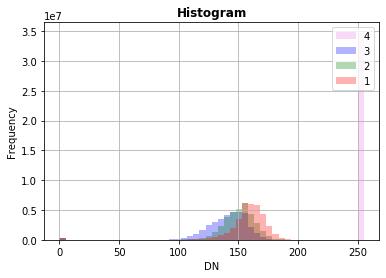

In [39]:
from rasterio.plot import show_hist
show_hist(datasetTrain, bins=50, lw=0.0, stacked=False, alpha=0.3,
        histtype='stepfilled', title="Histogram")

377364
377364
0.2324545478606463
0.03912896692442621


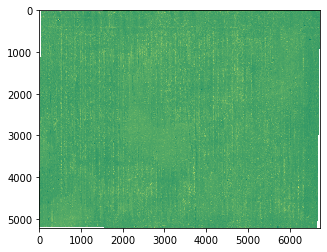

In [18]:
# ndvi
nir = train_img4
red = train_img1

def ndviCalc(red, nir):
    return ((nir - red)/(nir + red))

ndvi = ndviCalc(red, nir)
print(np.isnan(ndvi).sum())
ndvi[np.where(np.logical_or(ndvi < 0, ndvi > 1)) ] = np.nan 
print(np.isnan(ndvi).sum())
print(np.nanmean(ndvi))
print(np.nanstd(ndvi))
show(ndvi, cmap='summer')

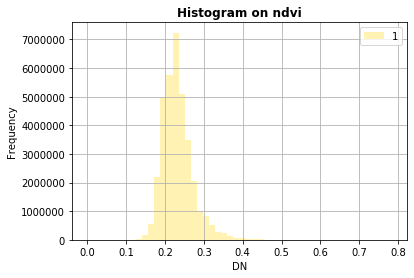

In [19]:
show_hist(ndvi, bins=50, lw=0.0, stacked=False, alpha=0.3,
        histtype='stepfilled', title="Histogram on ndvi")
plt.show()

In [20]:
truth.shape

(9534, 2)

-89.8129073071484 35.12524453356328 -89.81242023337595 35.12562160893812


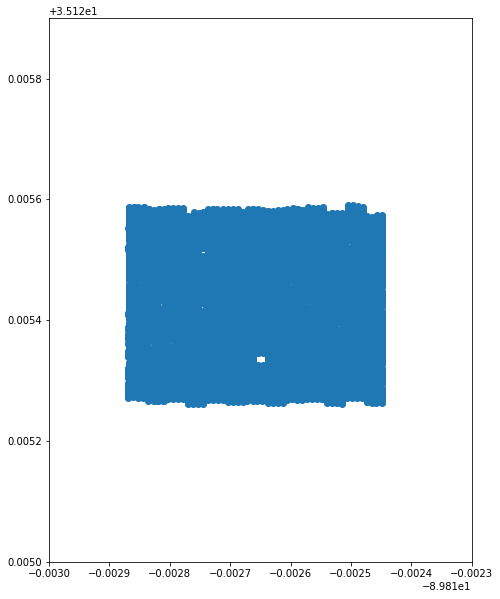

In [21]:
fig, ax = plt.subplots(figsize = (10,10))
truth.plot(ax=ax)
print(xmin, ymin, xmax, ymax)
plt.ylim([35.125, 35.1259])
plt.xlim([-89.813, -89.8123])
ylim = plt.gca().get_ylim()
xlim = plt.gca().get_xlim()
plt.show()

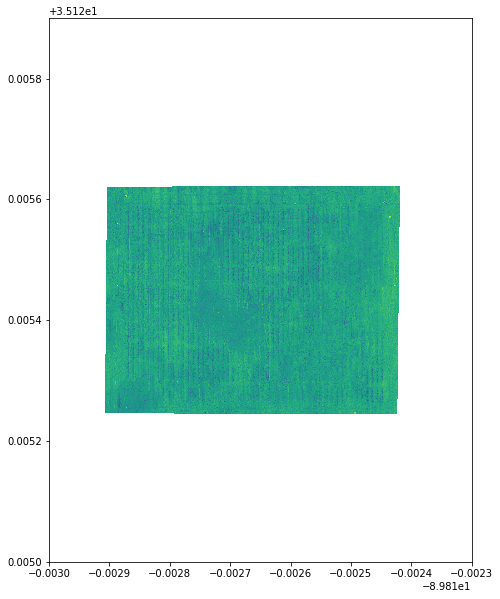

In [21]:
fig, ax = plt.subplots(figsize = (10,10))
plt.xlim(xlim)
plt.ylim(ylim)
show(datasetTrain)

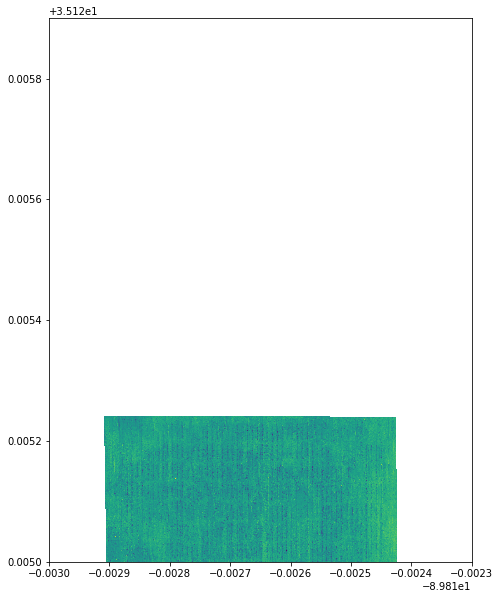

In [22]:
fig, ax = plt.subplots(figsize = (10,10))
plt.xlim(xlim)
plt.ylim(ylim)
show(datasetTest)

<IPython.core.display.Javascript object>


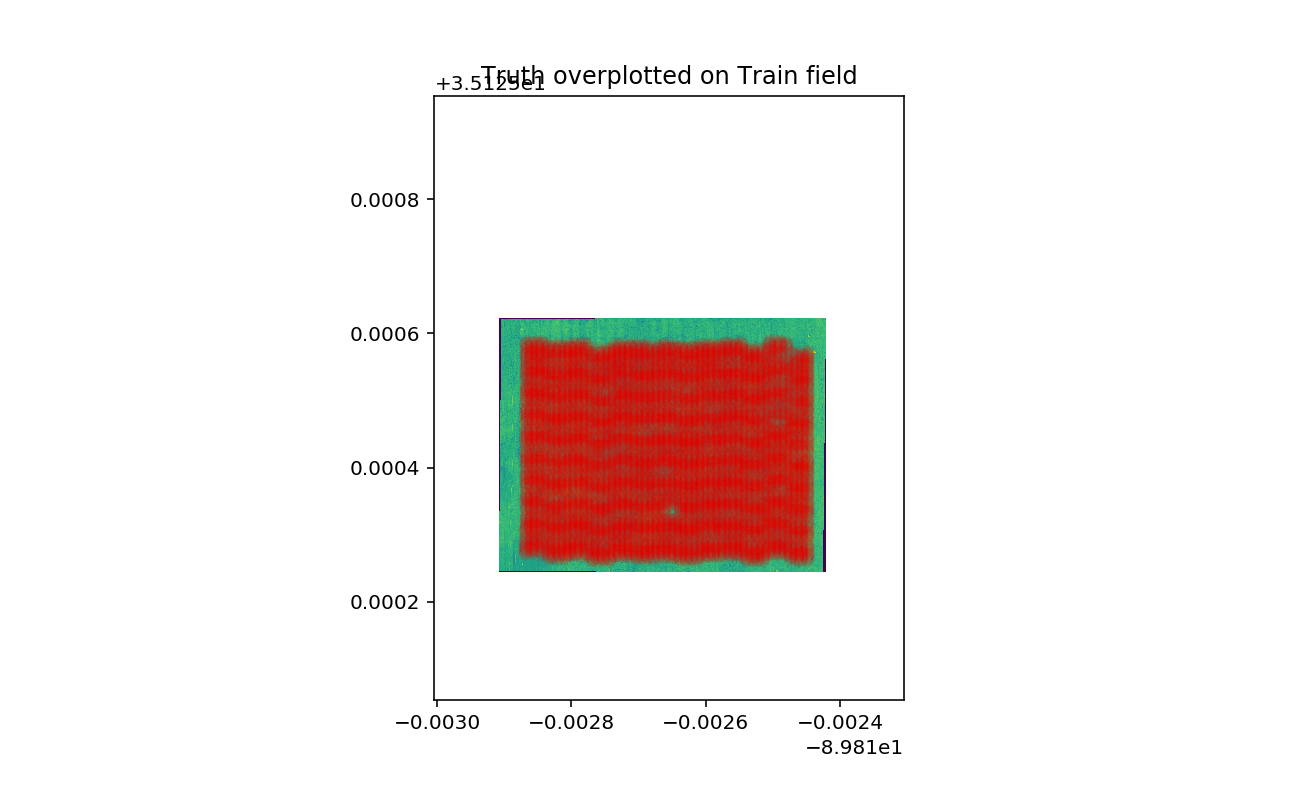

In [21]:
%matplotlib notebook

from rasterio.plot import show
fig, ax = plt.subplots()
show((datasetTrain, 1), ax=ax)
truth.plot(ax=ax, color='red', alpha=0.05)
plt.ylim([35.125, 35.1259])
plt.xlim([-89.813, -89.8123])

plt.title('Truth overplotted on Train field')
plt.show()

### ML

In [22]:
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn import neighbors
from skimage import feature, filters
from sklearn.cluster import MiniBatchKMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

### classification on pixels in ground truth 
Train: 
- use pixels as knn train

Test:
- predict pixels on train image
- predict pixels on test image, but we would have to know ytest (which I could "generate" using subset of the training data)

Predict:
- run model on the test field --> # of plants

In [23]:
# remove rows where ndvi is nan, since ML can train on those rows
badii = np.isnan(ndvi)
print(badii.sum(), len(ndvi.flatten()))

377364 35116290


In [24]:
# build ytarget based on ground truth
ytarget = np.zeros_like(train_img1)
import fiona
with fiona.open(truthf, "r") as shfile:
    features = [feature['geometry'] for feature in shfile]
    
for i in features:
    # get the x,y pix position of each corn pos 
    py, px = datasetTrain.index(*i['coordinates'])
    # print('Pixel Y, X coords: {}, {}'.format(py, px))
    ytarget[py, px] = 1.0
ytarget = ytarget[~badii].flatten().astype(int)

In [25]:
# build DF as X
X_train = pd.DataFrame()
X_train['b1'] = train_img1[~badii].flatten()
X_train['b2'] = train_img2[~badii].flatten()
X_train['b3'] = train_img3[~badii].flatten()
X_train['b4'] = train_img4[~badii].flatten()
X_train['ndvi'] = ndvi[~badii].flatten()
cnames = X_train.columns.values

In [26]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=cnames)
X_train.describe()

,b1,b2,b3,b4,ndvi
count,3.473893e+07,3.473893e+07,3.473893e+07,34738926.0,3.473893e+07
mean,5.723782e-01,5.182684e-01,4.903972e-01,0.0,2.967946e-01
std,5.695574e-02,6.068749e-02,6.767973e-02,0.0,4.995931e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00
25%,5.401786e-01,4.792627e-01,4.439462e-01,0.0,2.626013e-01
50%,5.758929e-01,5.207373e-01,4.977578e-01,0.0,2.922762e-01
75%,6.116071e-01,5.576037e-01,5.381166e-01,0.0,3.231178e-01
max,1.000000e+00,1.000000e+00,1.000000e+00,0.0,1.000000e+00


In [27]:
assert ytarget.shape[0] == X_train.shape[0]

/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/plotting/_misc.py:108: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(boundaries_list[j])
/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/plotting/_misc.py:109: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim(boundaries_list[i])
/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/plotting/_misc.py:100: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(boundaries_list[i])


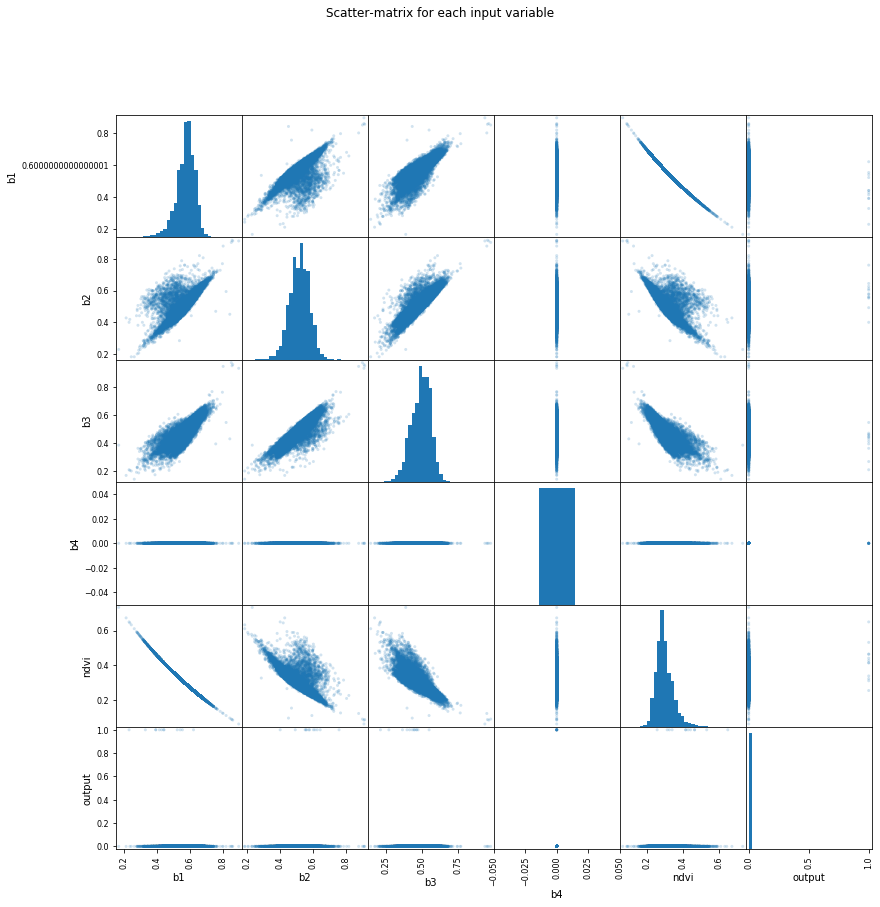

In [28]:
import copy
# Visualization of attributes/features with output
from pandas.plotting import scatter_matrix
import random

from matplotlib import cm
cmap = cm.get_cmap('gnuplot')
_X_train_tmp = X_train.copy(deep=True)
_X_train_tmp['output'] = ytarget
ax = scatter_matrix(_X_train_tmp.sample(n=30000), alpha=0.2, figsize=(15, 15),
                        hist_kwds={'bins': 35}) #,
                        # diagonal='kde')
plt.xticks(rotation=90)
plt.subplots_adjust(bottom=0.2, left=0.2)
plt.suptitle('Scatter-matrix for each input variable')
plt.show()

In [29]:
sns.countplot(x='output', data=_X_train_tmp, palette='hls')
plt.show()
print(_X_train_tmp['output'].sum()/len(_X_train_tmp['output']))

NameError: name 'sns' is not defined

### Split the training data so I could calculate test scores

In [ ]:
X_train_small, X_test_small, y_train_small, y_test_small = train_test_split(X_train, ytarget, test_size=0.3)

In [ ]:
### 0 and 1, so start w/ logistic 
logreg = LogisticRegression()
logreg.fit(X_train_small, y_train_small)

print('Accuracy of Logistic regression classifier on training set: {:.2f}'
     .format(logreg.score(X_train_small, y_train_small)))
print('Accuracy of Logistic regression classifier on test set: {:.2f}'
     .format(logreg.score(X_test_small, y_test_small)))

# this is probably because we have very imbalanced data.. most of the pixels are not plants

In [ ]:
### 0 and 1, so start w/ logistic 
logreg = LogisticRegression(class_weight='balanced')
logreg.fit(X_train_small, y_train_small)

print('Accuracy of Logistic regression classifier on training set: {:.2f}'
     .format(logreg.score(X_train_small, y_train_small)))
print('Accuracy of Logistic regression classifier on test set: {:.2f}'
     .format(logreg.score(X_test_small, y_test_small)))


### Tune hyperparameters? and CV
* Regularization using L2 to prevent terms from going to zero in L1

Deal with imbalance data
* upweight
* “Calibration”

In [ ]:
# gridsearch 
dual = [True, False]
max_iter = [100, 120, 140]
# C = [1.0,1.5,2.0,2.5]
param_grid = dict(dual=dual, max_iter=max_iter) #, C=C)

In [ ]:
# logreg_tuned = LogisticRegression(penalty='l2', class_weight='balanced')
# grid = GridSearchCV(estimator=logreg_tuned, param_grid=param_grid, cv=3, n_jobs=-1)
# grid_result = grid.fit(X_train_small, y_train_small)
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

In [105]:
# logreg_tuned = LogisticRegression(penalty='l2', **grid_result.best_params_)
# logreg_tuned.fit(X_train_small, y_train_small)
                                  
# print('Accuracy of Logistic regression classifier on training set: {:.2f}'
#      .format(logreg_tuned.score(X_train_small, y_train_small)))
# print('Accuracy of Logistic regression classifier on test set: {:.2f}'
#      .format(logreg_tuned.score(X_test_small, y_test_small)))
                                  

In [106]:
import sklearn.metrics as metrics
metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'accuracy', 'roc_auc', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'brier_score_loss', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

In [107]:
# stability using kCV, metric using accuracy
clf = logreg      # logreg_tuned

kfold = KFold(n_splits=3, random_state=7)
result = cross_val_score(clf, X_train, ytarget, cv=kfold, scoring='accuracy')
print(result.mean())

/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.9721147683149445


In [108]:
# Re-evaluate w/ diff. metric due to imbalanced data
result = cross_val_score(clf, X_train, ytarget, cv=kfold, scoring='balanced_accuracy')
print(result.mean())

/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.9703826967906695


In [109]:
print(y_test_small.sum())
print(len(y_test_small) - y_test_small.sum())

2814
10418864


[[10130709   288155]
 [      98     2716]]


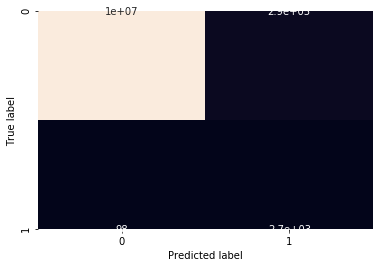

              precision    recall  f1-score   support

           0       1.00      0.97      0.99  10418864
           1       0.01      0.97      0.02      2814

    accuracy                           0.97  10421678
   macro avg       0.50      0.97      0.50  10421678
weighted avg       1.00      0.97      0.99  10421678



In [110]:
import matplotlib.pyplot as plt
import seaborn as sns

y_test_pred = clf.predict(X_test_small)
confusion = confusion_matrix(y_test_small, y_test_pred)
print(confusion)

sns.heatmap(confusion, annot=True, cbar=False)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

print(classification_report(y_test_small, y_test_pred))

### Read in test field data to calc number of obj

In [ ]:
with rasterio.open(testf) as src:
    profile = src.profile
    print(src.profile)
    
    (xmin, ymin, xmax, ymax) = src.bounds
    width = src.width
    height = src.height
#    print(src.descriptions)
    test_img1 = src.read(1).astype(float)
    test_img2 = src.read(2).astype(float)
    test_img3 = src.read(3).astype(float)
    test_img4 = src.read(4).astype(float)

    # Normalize band 
    test_img4_norm = normalize(test_img4)
    test_img3_norm = normalize(test_img3)
    test_img2_norm = normalize(test_img2)
    test_img1_norm = normalize(test_img1)    

red = test_img1
nir = test_img4
ndviTest = ndviCalc(red, nir)
print(np.isnan(ndviTest).sum())
ndvi[np.where(np.logical_or(ndviTest < 0, ndviTest > 1)) ] = np.nan 
print(np.isnan(ndviTest).sum())
print(np.nanmean(ndviTest))
print(np.nanstd(ndviTest))
show(ndviTest, cmap='summer')

In [ ]:
# remove rows where ndviTest is nan, since ML momdel not trained for those pixels
badiiTest = np.isnan(ndviTest)
print(badiiTest.sum(), len(ndviTest.flatten()))

In [ ]:
# build DF as X
XXX = pd.DataFrame()
XXX['b1'] = test_img1[~badiiTest].flatten()
XXX['b2'] = test_img2[~badiiTest].flatten()
XXX['b3'] = test_img3[~badiiTest].flatten()
XXX['b4'] = test_img4[~badiiTest].flatten()
XXX['ndvi'] = ndviTest[~badiiTest].flatten()
cnames = XXX.columns.values

In [ ]:
# generate X for the test field
XXX = scaler.fit_transform(XXX)
XXX = pd.DataFrame(XXX, columns=cnames)
XXX.describe()

In [ ]:
# run model on the test field
yyy_predict_logreg = clf.predict(XXX)

In [ ]:
print(yyy_predict_logreg.sum()/len(yyy_predict_logreg))
print(yyy_predict_logreg.sum())

In [ ]:
# summarizes the model’s performance by evaluating the trade offs between 
# true positive rate (sensitivity) and false positive rate(1- specificity)
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test_small, clf.predict(X_test_small))
fpr, tpr, thresholds = roc_curve(y_test_small, clf.predict_proba(X_test_small)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
# plt.savefig('Log_ROC')
plt.show()

### SVM Classifier 

In [ ]:
from sklearn.svm import SVC

SVM = SVC(kernel='linear', class_weight='balanced')
SVM.fit(X_train_small, y_train_small)

print('Accuracy of SVM classifier on training set: {:.2f}'
     .format(SVM.score(X_train_small, y_train_small)))
print('Accuracy of SVM classifier on test set: {:.2f}'
     .format(SVM.score(X_test_small, y_test_small)))

In [ ]:
y_pred_small = SVM.predict(X_test_small)
print("Precision:",metrics.precision_score(y_test_small, y_pred_small))
print("Recall:",metrics.recall_score(y_test_small, y_pred_small))

In [ ]:
clf = logreg      # logreg_tuned

kfold = KFold(n_splits=3, random_state=7)
result = cross_val_score(clf, X_train, ytarget, cv=kfold, scoring='accuracy')
print(result.mean())
# -

# Re-evaluate w/ diff. metric due to imbalanced data
result = cross_val_score(clf, X_train, ytarget, cv=kfold, scoring='balanced_accuracy')
print(result.mean())

In [ ]:
y_test_pred = SVM.predict(X_test_small)
confusion = confusion_matrix(y_test_small, y_test_pred)
print(confusion)

sns.heatmap(confusion, annot=True, cbar=False)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

print(classification_report(y_test_small, y_test_pred))

In [ ]:
# summarizes the model’s performance by evaluating the trade offs between 
# true positive rate (sensitivity) and false positive rate(1- specificity)
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test_small, clf.predict(X_test_small))
fpr, tpr, thresholds = roc_curve(y_test_small, clf.predict_proba(X_test_small)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='SVM Linear (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# run model on the test field
yyy_predict_linearSVM = clf.predict(XXX)

### Tuning Hyperparameters (maybe?)
- Kernel: The main function of the kernel is to transform the given dataset input data into the required form. There are various types of functions such as linear, polynomial, and radial basis function (RBF). Polynomial and RBF are useful for non-linear hyperplane. Polynomial and RBF kernels compute the separation line in the higher dimension. In some of the applications, it is suggested to use a more complex kernel to separate the classes that are curved or nonlinear. This transformation can lead to more accurate classifiers.

- Regularization: Regularization parameter in python's Scikit-learn C parameter used to maintain regularization. Here C is the penalty parameter, which represents misclassification or error term. The misclassification or error term tells the SVM optimization how much error is bearable. This is how you can control the trade-off between decision boundary and misclassification term. A smaller value of C creates a small-margin hyperplane and a larger value of C creates a larger-margin hyperplane.

- Gamma: (for non-linear). A lower value of Gamma will loosely fit the training dataset, whereas a higher value of gamma will exactly fit the training dataset, which causes over-fitting. In other words, you can say a low value of gamma considers only nearby points in calculating the separation line, while the a value of gamma considers all the data points in the calculation of the separation line.

### SMV: non-linear kernel, poly

In [ ]:
nfolds = 3
Cs = [0.1, 1, 10]
degrees = [1, 2, 3]
gammas = [0.1, 1, 10]
param_grid = {'C': Cs, 'degree': degrees, 'gamma' : gammas}
grid_search = GridSearchCV(estimator=SVC(kernel='poly'), param_grid, cv=nfolds)
grid_search.fit(X_train, ytarget)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

In [ ]:
SVM = SVC(kernel='poly', class_weight='balanced', **grid_result.best_params_)
SVM.fit(X_train_small, y_train_small)

print('Accuracy of SVM classifier on training set: {:.2f}'
     .format(SVM.score(X_train_small, y_train_small)))
print('Accuracy of SVM classifier on test set: {:.2f}'
     .format(SVM.score(X_test_small, y_test_small)))

y_pred_small = SVM.predict(X_test_small)
print("Precision:",metrics.precision_score(y_test_small, y_pred_small))
print("Recall:",metrics.recall_score(y_test_small, y_pred_small))

In [ ]:
clf = SVM    

kfold = KFold(n_splits=nfolds, random_state=7)
result = cross_val_score(clf, X_train, ytarget, cv=kfold, scoring='accuracy')
print(result.mean())
# -

# Re-evaluate w/ diff. metric due to imbalanced data
result = cross_val_score(clf, X_train, ytarget, cv=kfold, scoring='balanced_accuracy')
print(result.mean())

In [ ]:
y_test_pred = clf.predict(X_test_small)
confusion = confusion_matrix(y_test_small, y_test_pred)
print(confusion)

sns.heatmap(confusion, annot=True, cbar=False)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

print(classification_report(y_test_small, y_test_pred))

In [ ]:
# run model on the test field
yyy_predict_polySVM = clf.predict(XXX)

In [ ]:
# summarizes the model’s performance by evaluating the trade offs between 
# true positive rate (sensitivity) and false positive rate(1- specificity)
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test_small, clf.predict(X_test_small))
fpr, tpr, thresholds = roc_curve(y_test_small, clf.predict_proba(X_test_small)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='SVM Linear (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

### SMV: non-linear kernel, rbf

In [ ]:
nfolds = 3
Cs = [0.1, 1, 10]
gammas = [0.1, 1, 10]
param_grid = {'C': Cs, 'gamma' : gammas}
grid_search = GridSearchCV(estimator=SVC(kernel='rbf'), param_grid, cv=nfolds)
grid_search.fit(X_train, ytarget)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

In [ ]:
SVM = SVC(kernel='rbf', class_weight='balanced', **grid_result.best_params_)
SVM.fit(X_train_small, y_train_small)

print('Accuracy of SVM classifier on training set: {:.2f}'
     .format(SVM.score(X_train_small, y_train_small)))
print('Accuracy of SVM classifier on test set: {:.2f}'
     .format(SVM.score(X_test_small, y_test_small)))

y_pred_small = SVM.predict(X_test_small)
print("Precision:",metrics.precision_score(y_test_small, y_pred_small))
print("Recall:",metrics.recall_score(y_test_small, y_pred_small))

In [ ]:
clf = SVM    

kfold = KFold(n_splits=nfolds, random_state=7)
result = cross_val_score(clf, X_train, ytarget, cv=kfold, scoring='accuracy')
print(result.mean())
# -

# Re-evaluate w/ diff. metric due to imbalanced data
result = cross_val_score(clf, X_train, ytarget, cv=kfold, scoring='balanced_accuracy')
print(result.mean())

In [ ]:
y_test_pred = clf.predict(X_test_small)
confusion = confusion_matrix(y_test_small, y_test_pred)
print(confusion)

sns.heatmap(confusion, annot=True, cbar=False)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

print(classification_report(y_test_small, y_test_pred))

In [ ]:
# summarizes the model’s performance by evaluating the trade offs between 
# true positive rate (sensitivity) and false positive rate(1- specificity)
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test_small, clf.predict(X_test_small))
fpr, tpr, thresholds = roc_curve(y_test_small, clf.predict_proba(X_test_small)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='SVM Linear (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# run model on the test field
yyy_predict_rbfSVM = clf.predict(XXX)

### RFC

In [ ]:
from pprint import pprint
rfc = RandomForestClassifier(class_weight='balanced')
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rfc.get_params())

rfc.fit(X_train_small,y_train_small)

print('Accuracy of RF classifier on training set: {:.2f}'
     .format(rfc.score(X_train_small, y_train_small)))
print('Accuracy of RF classifier on test set: {:.2f}'
     .format(rfc.score(X_test_small, y_test_small)))

y_pred_small = rfc.predict(X_test_small)
print("Precision:",metrics.precision_score(y_test_small, y_pred_small))
print("Recall:",metrics.recall_score(y_test_small, y_pred_small))

### hyperparam
- n_estimators = number of trees in the foreset
- max_features = max number of features considered for splitting a node
- max_depth = max number of levels in each decision tree
- min_samples_split = min number of data points placed in a node before the node is split
- min_samples_leaf = min number of data points allowed in a leaf node
- bootstrap = method for sampling data points (with or without replacement)

In [ ]:
nfolds = 3
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [5, 20, 100]
max_features = ['auto', 'sqrt']
max_depth = [10, 50, 100]
max_depth.append(None)

min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]

bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

grid_search = RandomizedSearchCV(estimator=rfc, 
                                 param_distributions=random_grid, 
                                 cv=nfolds,
                                 verbose=2)
grid_search.fit(X_train, ytarget)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

In [ ]:
rfc = RandomForestRegressor(class_weight='balanced', **grid_result.best_params_)
rfc.fit(X_train_small, y_train_small)

print('Accuracy of rf classifier on training set: {:.2f}'
     .format(rfc.score(X_train_small, y_train_small)))
print('Accuracy of rf classifier on test set: {:.2f}'
     .format(rfc.score(X_test_small, y_test_small)))

y_pred_small = rfc.predict(X_test_small)
print("Precision:",metrics.precision_score(y_test_small, y_pred_small))
print("Recall:",metrics.recall_score(y_test_small, y_pred_small))


In [ ]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True], # ......
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
# Create a based model
rfc = RandomForestRegressor(class_weight='balanced')
# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, 
                          cv=nfolds, n_jobs=-1, verbose=2)

In [ ]:
# ROC and AUC
logit_roc_auc = roc_auc_score(y_test_small, clf.predict(X_test_small))
fpr, tpr, thresholds = roc_curve(y_test_small, clf.predict_proba(X_test_small)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='RF (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

In [ ]:
yyy_predict_rfc = clf.predict(XXX)